This notebook is part of Andreu's (esdandreu@gmail.com) Master Thesis work at
Keio University.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AcousticOdometry/AO/blob/main/notebooks/odometry.ipynb)


# Setup

This section will take care of installing the necessary packages as well as
configuring some environment variables.


## Colab

Assess wether the notebook is being executed in [Google
Colab](https://colab.research.google.com/) and if so, set up the software
needed in Colab runtime.


In [1]:
%%capture
try:
    from google import colab
    COLAB_RUNTIME = True
    %pip install torchinfo
    colab.drive.mount('/content/drive')
except ImportError:
    COLAB_RUNTIME = False

## Packages


In [13]:
import math
import numpy as np
import pandas as pd

from pathlib import Path
from typing import Tuple
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

### AO

Setup Acoustic Odometry python package. If this notebook is being executed in
[Colab](#colab), the package will be installed from Github. Because of this, a
Github [personal access
token](https://docs.github.com/en/authentication/keeping-your-account-and-data-secure/creating-a-personal-access-token)
is needed for the installation.

If the notebook is not running on Colab and the package is not already
installed, installation instructions will be prompted.


In [3]:
if COLAB_RUNTIME:
    import subprocess
    import requests
    import sys
    import os
    #@markdown Use a [GitHub Personal Access Token](https://docs.github.com/en/authentication/keeping-your-account-and-data-secure/creating-a-personal-access-token)
    GITHUB_TOKEN = ''  #@param {type:"string"}
    auth = requests.auth.HTTPBasicAuth('', GITHUB_TOKEN)
    response = requests.get(
        "https://api.github.com/repos/AcousticOdometry/AO/releases/latest",
        auth=auth
        )
    try:
        response.raise_for_status()
    except requests.HTTPError as e:
        raise RuntimeError(
            'Check GITHUB_TOKEN is a Personal Access Token with repo access'
            )
    headers = {'Accept': 'application/octet-stream'}
    for asset in response.json()['assets']:
        r = requests.get(
            asset['url'], auth=auth, allow_redirects=True, headers=headers
            )
        r.raise_for_status()
        wheel_name = asset['name']
        with open(wheel_name, 'wb') as f:
            f.write(r.content)
        try:
            result = subprocess.check_output([
                sys.executable, '-m', 'pip', 'install', wheel_name
                ])
            print(f'Installed {wheel_name}')
            break
        except subprocess.CalledProcessError as e:
            pass
        finally:
            os.remove(wheel_name)
    import ao
else:
    try:
        import ao
    except ImportError:
        raise ImportError(
            "Acoustic Odometry python extension is not installed. Check "
            r"https://github.com/AcousticOdometry/AO#readme"
            " for detailed instructions."
            )

# Odometry

In [4]:
if COLAB_RUNTIME:
    # @markdown Check where is the experiment folder situated in your drive folder.
    # @markdown Remember that if you have been shared the folder, you can
    # @markdown [add a shortcut to your drive](https://support.google.com/drive/answer/9700156?hl=en&co=GENIE.Platform%3DDesktop)
    # @markdown in order to make it available in google colab.
    experiment = "/content/drive/MyDrive/VAO_WheelTestBed-Experiment-2"  #@param {type:"string"}
    EXPERIMENT_FOLDER = Path(experiment)
    if not EXPERIMENT_FOLDER.is_dir():
        raise RuntimeError(f'Invalid experiment folder {EXPERIMENT_FOLDER}')
else:
    EXPERIMENT_FOLDER = ao.dataset.utils.get_folder(
        env='WHEELTESTBED_EXPERIMENT2'
        )
VALIDATION_FOLDER = EXPERIMENT_FOLDER / 'validation-recordings'
MODELS_FOLDER = Path().resolve().parent / 'models'
print(MODELS_FOLDER)

/Users/esdandreu/Desktop/AO/models


## Generate recording ground truth

The recording is composed by audio files from several devices that span for the
whole experiment and several wheel test bed control files that span for certain
parts of the experiment. In this section we combine the control files in order
to generate a unique ground truth for the whole recording.

In [5]:
recording = VALIDATION_FOLDER / 'date_2022-05-20;time_16-59-56'

def get_recording_bounds(recording: Path) -> Tuple[float, float]:
    start_timestamp = np.Inf
    end_timestamp = 0
    for wav_file in recording.glob('microphone*.wav'):
        config = ao.io.yaml_load(wav_file.with_suffix('.yaml'))
        start_timestamp = min(start_timestamp, config['start_timestamp'])
        end_timestamp = max(end_timestamp, config['end_timestamp'])
    return start_timestamp, end_timestamp

get_recording_bounds(recording=recording)

(1653033646.109341, 1653033821.222812)

In [6]:
def generate_recording_ground_truth(recording: Path) -> pd.DataFrame:
    start_timestamp, end_timestamp = get_recording_bounds(recording)
    gt = pd.DataFrame(columns=['X', 'Vx', 'Vw', 'slip', 'wheel_rotation'])
    gt.loc[start_timestamp] = np.zeros(len(gt.columns))
    for control_file in sorted(recording.glob('*.csv')):
        if control_file.stem == 'ground_truth':
            continue
        df = pd.read_csv(
            control_file,
            index_col='timestamp',
            usecols=['timestamp'] + list(gt.columns),
            parse_dates=True,
            )
        # Accumulable columns
        for col in ['X', 'wheel_rotation']:
            df[col] = df[col] + gt[col].iloc[-1]
        # Wheel stops at the end of the movement, assume stopped after 100 ms
        df.loc[df.tail(1).index.item() + 0.1] = df.iloc[-1].copy()
        # Update the first and last row with null velocities
        for col in ['Vx', 'Vw', 'slip']:
            col_index = gt.columns.get_loc(col)
            df.iloc[0, col_index] = 0
            df.iloc[-1, col_index] = 0
        # After each control the wheel stops
        gt = pd.concat([gt, df])
    gt.loc[end_timestamp] = gt.iloc[-1].copy()
    for col in ['Vx', 'Vw', 'slip']:
        col_index = gt.columns.get_loc(col)
        gt.iloc[-1, col_index] = 0
    gt.loc[:, 'X'] /= 1000 # [mm] -> [m]
    return gt

ground_truth = generate_recording_ground_truth(recording=recording)
ground_truth.head()

,X,Vx,Vw,slip,wheel_rotation
1.653034e+09,0.00000,0.0000,0.0000,0.00000,0.000000
1.653034e+09,0.00000,0.0000,0.0000,0.00000,0.002397
1.653034e+09,0.00011,0.0011,7.0113,0.91011,0.703520
1.653034e+09,0.00129,0.0118,9.8078,0.31066,1.684300
1.653034e+09,0.00371,0.0242,10.1710,-0.36320,2.701400


,X,Vx,Vw,slip,wheel_rotation,tx
timestamp,,,,,,
1.653034e+09,0.00000,0.0000,0.0000,0.00000,0.000000,0.00000
1.653034e+09,0.00000,0.0000,0.0000,0.00000,0.002397,0.00000
1.653034e+09,0.00011,0.0011,7.0113,0.91011,0.703520,0.00011
1.653034e+09,0.00129,0.0118,9.8078,0.31066,1.684300,0.00118
1.653034e+09,0.00371,0.0242,10.1710,-0.36320,2.701400,0.00242


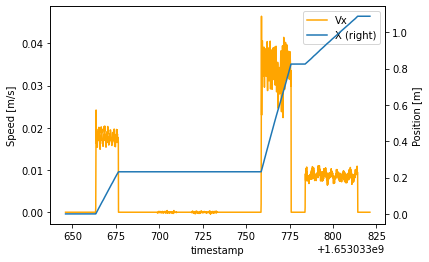

In [7]:
def get_recording_ground_truth(recording: Path) -> pd.DataFrame:
    ground_truth_path = recording / 'ground_truth.csv'
    if ground_truth_path.exists():
        gt = pd.read_csv(ground_truth_path, index_col='timestamp')
    else:
        gt = generate_recording_ground_truth(recording)
        gt.to_csv(ground_truth_path, index_label='timestamp')
    gt['tx'] = gt['X'].diff()
    gt.iloc[0, gt.columns.get_loc('tx')] = 0
    return gt


ground_truth = get_recording_ground_truth(recording=recording)
ax = ground_truth.plot(y=['Vx'], ylabel='Speed [m/s]', color='orange')
ground_truth.plot(ax=ax, y=['X'], secondary_y=True).set_ylabel('Position [m]')
ground_truth.head()

## Apply model to recording

In [8]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(DEVICE))

Using cpu device


In [9]:
extractors = [
    ao.extractor.GammatoneFilterbank(
        num_samples=int(10 * 44100 / 1000),
        num_features=256,
        sample_rate=44100,
        )
    ]
model = ao.AO(
    model_path=MODELS_FOLDER /
    'torch-script;name_numpy-arrays;date_2022-05-23;time_13-39-14.pt',
    extractors=extractors,
    num_frames=120,
    )


In [11]:
def odometry_from_file(wav_file: Path, model: AO) -> pd.DataFrame:
    wav_data, _ = ao.io.wave_read(wav_file)
    config = ao.io.yaml_load(wav_file.with_suffix('.yaml'))
    start = config['start_timestamp']
    step = model.num_samples / model.sample_rate
    frames = ao.dataset.audio._frames(wav_data, model.num_samples)
    timestamps = np.linspace(start, start + len(frames) * step, len(frames))
    Vx = np.zeros(len(frames))
    for i, frame in tqdm(enumerate(frames), total=len(frames), unit='frames'):
        Vx[i] = model(frame.mean(axis=1))
    # Compute X translations and cumulative X position
    Vx = pd.Series(Vx, index=timestamps) / 100  # [cm/s] -> [m/s]
    odom = pd.concat([Vx, Vx.index.to_series().diff() * Vx], axis=1)
    odom.columns = ['Vx', 'tx']
    odom.iloc[0, :] = 0
    odom['X'] = odom['tx'].cumsum()
    return odom


odom = odometry_from_file(wav_file=recording / f'microphone0.wav', model=model)
odom.head()

  0%|          | 0/17307 [00:00<?, ?frames/s]

,Vx,tx,X
1.653034e+09,0.0,0.0,0.0
1.653034e+09,0.0,0.0,0.0
1.653034e+09,0.0,0.0,0.0
1.653034e+09,0.0,0.0,0.0
1.653034e+09,0.0,0.0,0.0


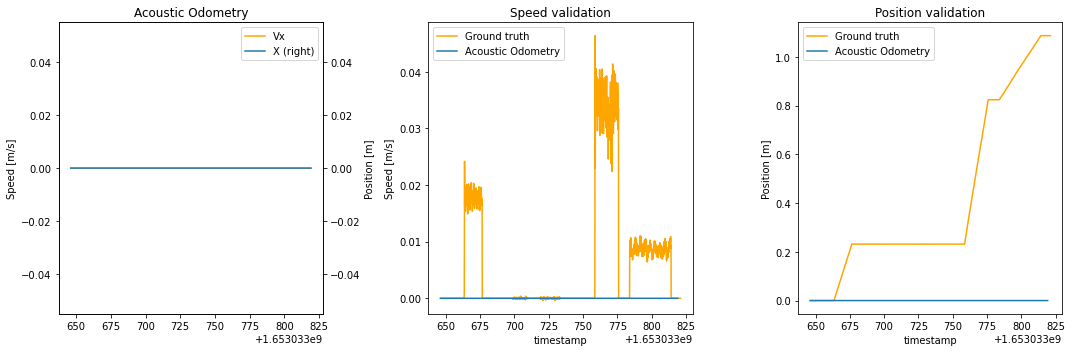

In [12]:
def plot_acoustic_odometry(odom: pd.DataFrame, ground_truth: pd.DataFrame):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].set_title('Acoustic Odometry')
    ax = odom.plot(ax=axs[0], y=['Vx'], ylabel='Speed [m/s]', color='orange')
    odom.plot(ax=ax, y=['X'], secondary_y=True).set_ylabel('Position [m]')
    axs[1].set_title('Speed validation')
    ax = ground_truth.plot(
        ax=axs[1],
        y=['Vx'],
        ylabel='Speed [m/s]',
        color='orange',
        label=['Ground truth']
        )
    odom.plot(ax=ax, y=['Vx'], label=['Acoustic Odometry'])
    axs[2].set_title('Position validation')
    ax = ground_truth.plot(
        ax=axs[2],
        y=['X'],
        ylabel='Position [m]',
        color='orange',
        label=['Ground truth']
        )
    odom.plot(ax=ax, y=['X'], label=['Acoustic Odometry'])
    fig.tight_layout()
    return fig, axs

_ = plot_acoustic_odometry(odom, ground_truth)

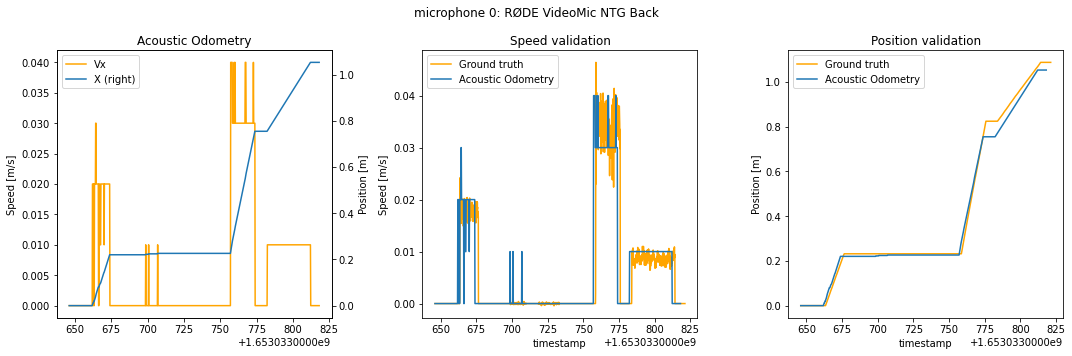

In [27]:
def validate_acoustic_odometry(
        recording: Path, microphone: int
    ) -> pd.DataFrame:
    ground_truth = get_recording_ground_truth(recording=recording)
    wav_file = recording / f'microphone{microphone}.wav'
    odom = acoustic_odometry(
        wav_file=wav_file,
        model_path=MODELS_FOLDER /
        'name_numpy-arrays;date_2022-05-23;time_13-39-14.pt'
        )
    fig, _ = plot_acoustic_odometry(odom, ground_truth)
    # Load config and set title
    config = ao.io.yaml_load(wav_file.with_suffix('.yaml'))
    fig.suptitle(f"microphone {microphone}: {config['name']}")
    fig.tight_layout()
    return odom

results = []
results.append(validate_acoustic_odometry(recording=recording, microphone=0))

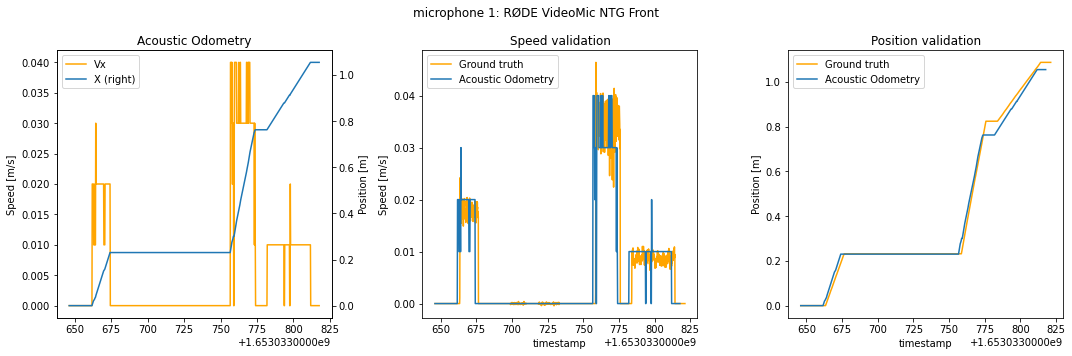

In [28]:
results.append(validate_acoustic_odometry(recording=recording, microphone=1))

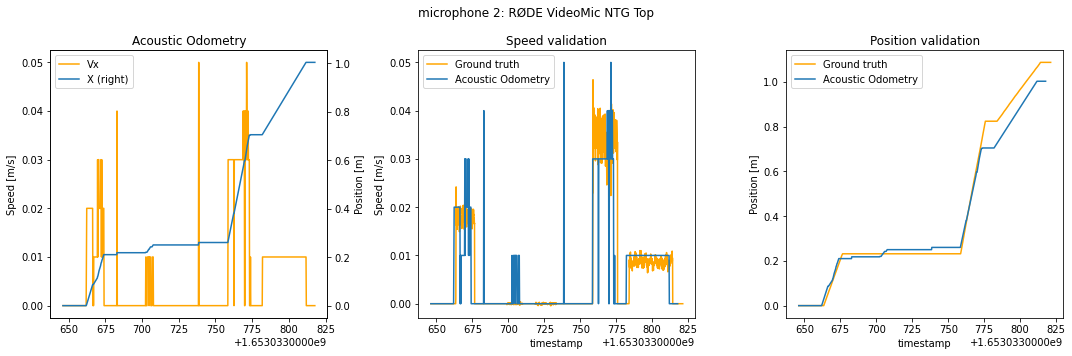

In [66]:
results.append(validate_acoustic_odometry(recording=recording, microphone=2))

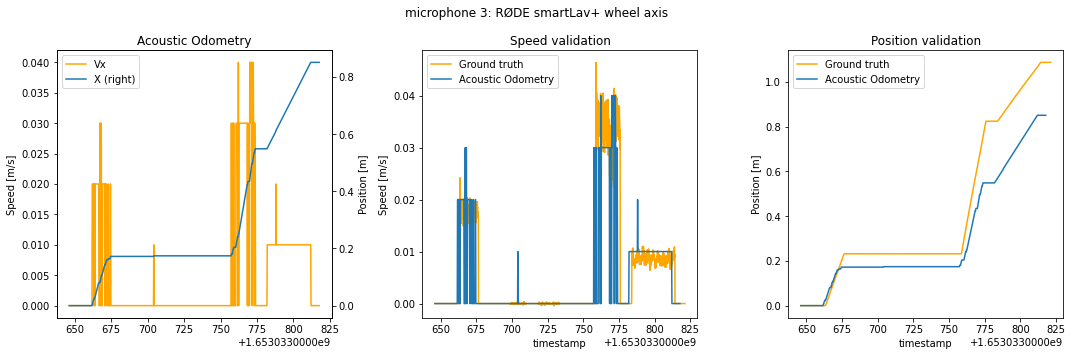

In [67]:
results.append(validate_acoustic_odometry(recording=recording, microphone=3))

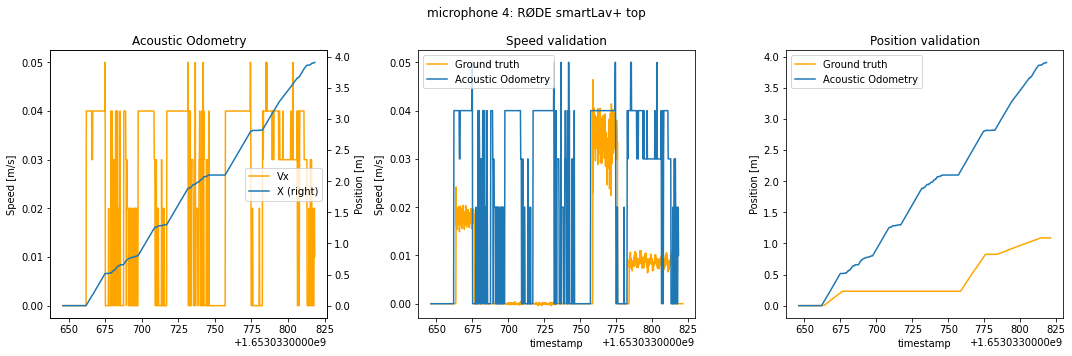

In [68]:
results.append(validate_acoustic_odometry(recording=recording, microphone=4))

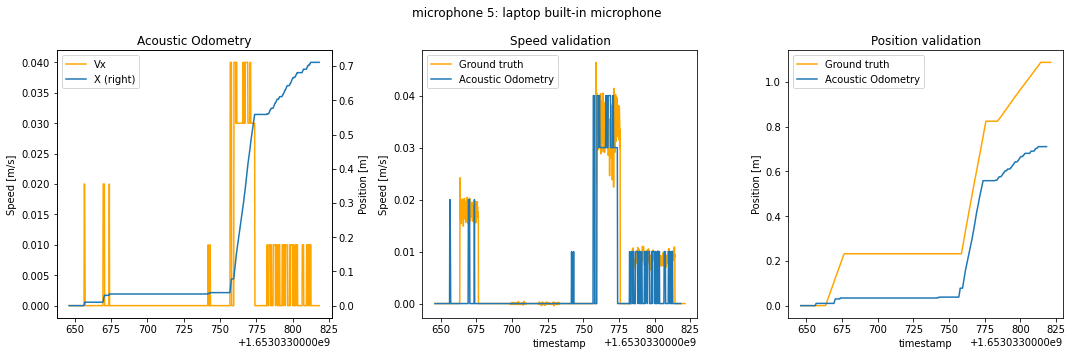

In [69]:
results.append(validate_acoustic_odometry(recording=recording, microphone=5))

## Evaluate the results

In [166]:
ATE = {}
gt_tx = ground_truth['tx'].to_numpy()
gt_X = ground_truth['X'].to_numpy()
gt_timestamps = ground_truth.index.to_numpy()
for mic, odom in enumerate(results):
    # Estimation timestamps
    ATE[mic] = {'timestamps': odom.index.to_numpy()}
    # Interpolate ground truth to estimation timestamps
    sync_gt_tx = np.interp(ATE[mic]['timestamps'], gt_timestamps, gt_tx)
    sync_gt_X = np.interp(ATE[mic]['timestamps'], gt_timestamps, gt_X)
    # Calculate error
    ATE[mic]['error'] = np.absolute(sync_gt_tx - odom['tx'].to_numpy())
    ATE[mic]['cumulative_error'] = np.absolute(
        sync_gt_X - odom['X'].to_numpy()
        )
    device_file = recording / f'microphone{mic}.yaml'
    ATE[mic]['config'] = ao.io.yaml_load(device_file)

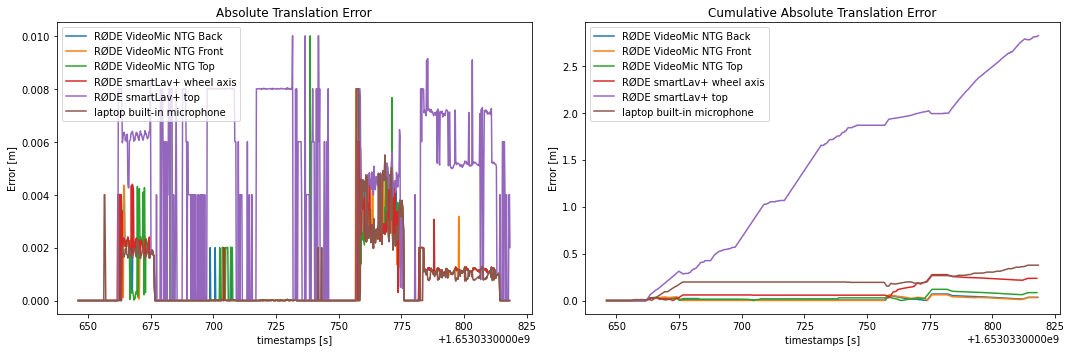

In [175]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
for ax, get_x, title in zip(
    axs, [lambda x: x['error'], lambda x: x['cumulative_error']],
    ['Absolute Translation Error', 'Absolute Position Error']
    ):
    for result in ATE.values():
        ax.plot(
            result['timestamps'],
            get_x(result),
            label=result['config']['name']
            )
    ax.set_ylabel('Error [m]')
    ax.set_xlabel('timestamps [s]')
    ax.set_title(title)
    ax.legend()
fig.tight_layout()

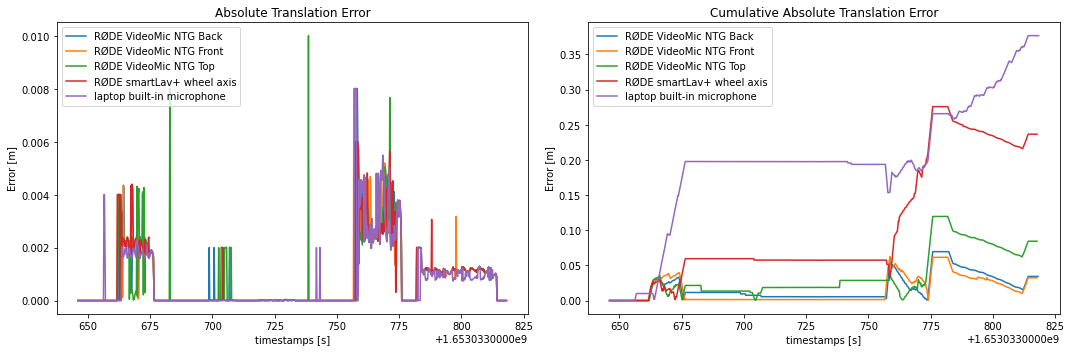

In [174]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
for ax, get_x, title in zip(
    axs, [lambda x: x['error'], lambda x: x['cumulative_error']],
    ['Absolute Translation Error', 'Absolute Position Error']
    ):
    for mic, result in ATE.items():
        if mic == 4:
            continue
        ax.plot(
            result['timestamps'],
            get_x(result),
            label=result['config']['name']
            )
    ax.set_ylabel('Error [m]')
    ax.set_xlabel('timestamps [s]')
    ax.set_title(title)
    ax.legend()
fig.tight_layout()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


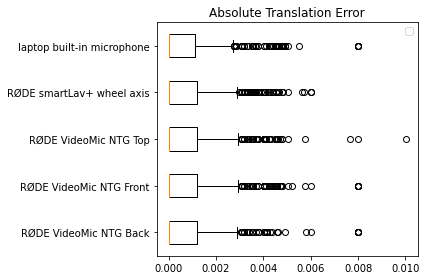

In [176]:
fig, ax = plt.subplots(1, 1)
results_to_plot = [result for mic, result in ATE.items() if mic != 4]
ax.boxplot(
    [result['error'] for result in results_to_plot],
    labels=[result['config']['name'] for result in results_to_plot],
    vert=False
    )
ax.set_title('Absolute Translation Error')
ax.legend()
fig.tight_layout()